# 2. Data preprocessing and basic models

## 2.1 Imports

In [1]:
import category_encoders as ce
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import warnings

from numpy import savetxt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

%matplotlib inline
warnings.filterwarnings('ignore')
seed = 101

C:\Users\brtkr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
Housing = pd.read_csv("../Data/HousingCleaned.csv", parse_dates=['SaleDate'])

In [3]:
Housing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         13580 non-null  object        
 1   Rooms          13580 non-null  int64         
 2   Type           13580 non-null  object        
 3   Price          13580 non-null  float64       
 4   Method         13580 non-null  object        
 5   SaleDate       13580 non-null  datetime64[ns]
 6   Distance       13580 non-null  float64       
 7   Bedrooms       13580 non-null  float64       
 8   Bathrooms      13580 non-null  float64       
 9   CarSpots       13518 non-null  float64       
 10  LandSize       13580 non-null  float64       
 11  BuildingArea   7130 non-null   float64       
 12  YearBuilt      8205 non-null   float64       
 13  CouncilArea    12211 non-null  object        
 14  Latitude       13580 non-null  float64       
 15  Longitude      1358

## 2.2 Data preprocessing

### 2.2.1 NaN values elimination

In [4]:
Housing.isna().sum().iloc[Housing.isna().sum().to_numpy().nonzero()]

CarSpots          62
BuildingArea    6450
YearBuilt       5375
CouncilArea     1369
dtype: int64

In [5]:
Housing.tail(5)

,Suburb,Rooms,Type,Price,Method,SaleDate,Distance,Bedrooms,Bathrooms,CarSpots,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount
13575,Wheelers Hill,4,h,1245000.0,S,2017-08-26,16.7,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,3,h,1031000.0,SP,2017-08-26,6.8,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,3,h,1170000.0,S,2017-08-26,6.8,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,4,h,2500000.0,PI,2017-08-26,6.8,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0
13579,Yarraville,4,h,1285000.0,SP,2017-08-26,6.3,4.0,1.0,1.0,362.0,112.0,1920.0,NaN,-37.81188,144.88449,Western Metropolitan,6543.0


In [6]:
suburb = Housing[Housing['CouncilArea'].isna()].loc[:,['Suburb']]
suburb = suburb['Suburb'].unique().tolist()

council = []

for i in suburb:
    try:
        element = Housing[Housing['Suburb'] == i].loc[:,['CouncilArea']].mode().iloc[0][0]
        council.append(element)
    except:
        element = Housing['CouncilArea'].mode().iloc[0]
        council.append(element)

council_dict = {suburb[i]: council[i] for i in range(len(suburb))}

Function above creates dictionary where every suburb (containing at least one property with NaN council area) is assigned to proper council area (It is possible because council area is broader concept than suburb). With this dictionary, imputation of council area can be implemented based on suburb value as it does code below.

In [7]:
for i, row in Housing.iterrows():
    if type(row['CouncilArea']) != str:
        for key, value in council_dict.items():
            if row['Suburb'] == key:
                Housing.loc[i,'CouncilArea'] = value

In [8]:
Housing.sort_values(by='LandSize', inplace=True)
Housing['BuildingArea'].fillna(method='bfill', inplace=True)

In [9]:
Housing.sort_values(by='Price', inplace=True)
Housing['YearBuilt'].fillna(method='ffill', inplace=True)


In [10]:
Housing['CarSpots'].fillna(value=Housing['CarSpots'].mode()[0], inplace=True)

Other NaN imputation is done with more typical methods (bfill, ffill, statistical mode).

### 2.2.2 Outliers detection and treatment

In [11]:
Housing[Housing['PropertyCount'] > 20000].sample(5)

,Suburb,Rooms,Type,Price,Method,SaleDate,Distance,Bedrooms,Bathrooms,CarSpots,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount
5086,Reservoir,3,u,301000.0,SP,2016-10-09,11.2,3.0,1.0,1.0,0.0,63.0,1970.0,Darebin,-37.72720,145.00570,Northern Metropolitan,21650.0
9301,Reservoir,3,t,642500.0,S,2017-03-06,12.0,3.0,2.0,2.0,160.0,140.0,2010.0,Darebin,-37.71064,145.01067,Northern Metropolitan,21650.0
5061,Reservoir,4,h,851000.0,S,2016-07-11,11.2,4.0,2.0,2.0,581.0,244.0,2006.0,Darebin,-37.69260,144.98610,Northern Metropolitan,21650.0
10483,Reservoir,3,h,700000.0,S,2017-05-27,12.0,3.0,2.0,1.0,301.0,380.0,1950.0,Darebin,-37.72839,145.00105,Northern Metropolitan,21650.0
13527,Reservoir,4,h,1112000.0,S,2017-08-26,12.0,4.0,2.0,10.0,1002.0,170.0,1985.0,Darebin,-37.70671,145.03086,Northern Metropolitan,21650.0


<AxesSubplot:ylabel='Longitude'>

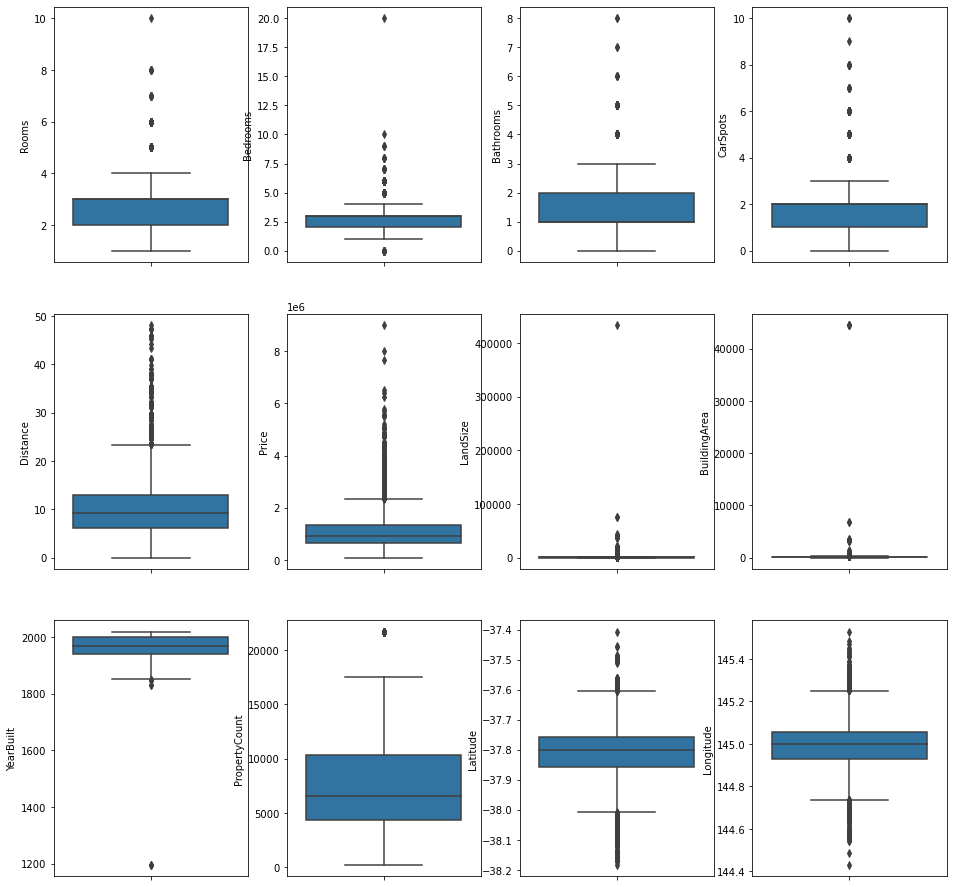

In [12]:
f, ax = plt.subplots(3, 4, figsize=(16,16))

sns.boxplot(ax=ax[0,0], data=Housing, y='Rooms')
sns.boxplot(ax=ax[0,1], data=Housing, y='Bedrooms')
sns.boxplot(ax=ax[0,2], data=Housing, y='Bathrooms')
sns.boxplot(ax=ax[0,3], data=Housing, y='CarSpots')
sns.boxplot(ax=ax[1,0], data=Housing, y='Distance')
sns.boxplot(ax=ax[1,1], data=Housing, y='Price')
sns.boxplot(ax=ax[1,2], data=Housing, y='LandSize')
sns.boxplot(ax=ax[1,3], data=Housing, y='BuildingArea')
sns.boxplot(ax=ax[2,0], data=Housing, y='YearBuilt')
sns.boxplot(ax=ax[2,1], data=Housing, y='PropertyCount')
sns.boxplot(ax=ax[2,2], data=Housing, y='Latitude')
sns.boxplot(ax=ax[2,3], data=Housing, y='Longitude')

Most significant outliers belong to YearBuilt, Landsize, BuildingArea variables.

In [13]:
Housing.shape

(13580, 18)

In [14]:
Housing = Housing[Housing['Bathrooms'] < 5]
Housing = Housing[Housing['CarSpots'] < 5]
Housing = Housing[Housing['Rooms'] < 7]
Housing = Housing[Housing['Bedrooms'] < 7]
Housing = Housing[Housing['YearBuilt'] > 1800]

It was decided that outliers of five features above will be eliminated manualy (because of narrow range of values). On three other features with significant outliers was used IQR method. 

In [15]:
outliered = ["Price", "LandSize", "BuildingArea"]

for x in outliered:
    Q1 = np.percentile(Housing[f'{x}'], 25, interpolation='midpoint')
    Q3 = np.percentile(Housing[f'{x}'], 75, interpolation='midpoint')
    IQR = Q3 - Q1

    Housing = Housing[Housing[f'{x}'] <= (Q3+1.5*IQR)]
    Housing = Housing[Housing[f'{x}'] >= (Q1-1.5*IQR)]

In [16]:
Housing.shape

(11938, 18)

This process eliminated 1642 rows.

<AxesSubplot:ylabel='Longitude'>

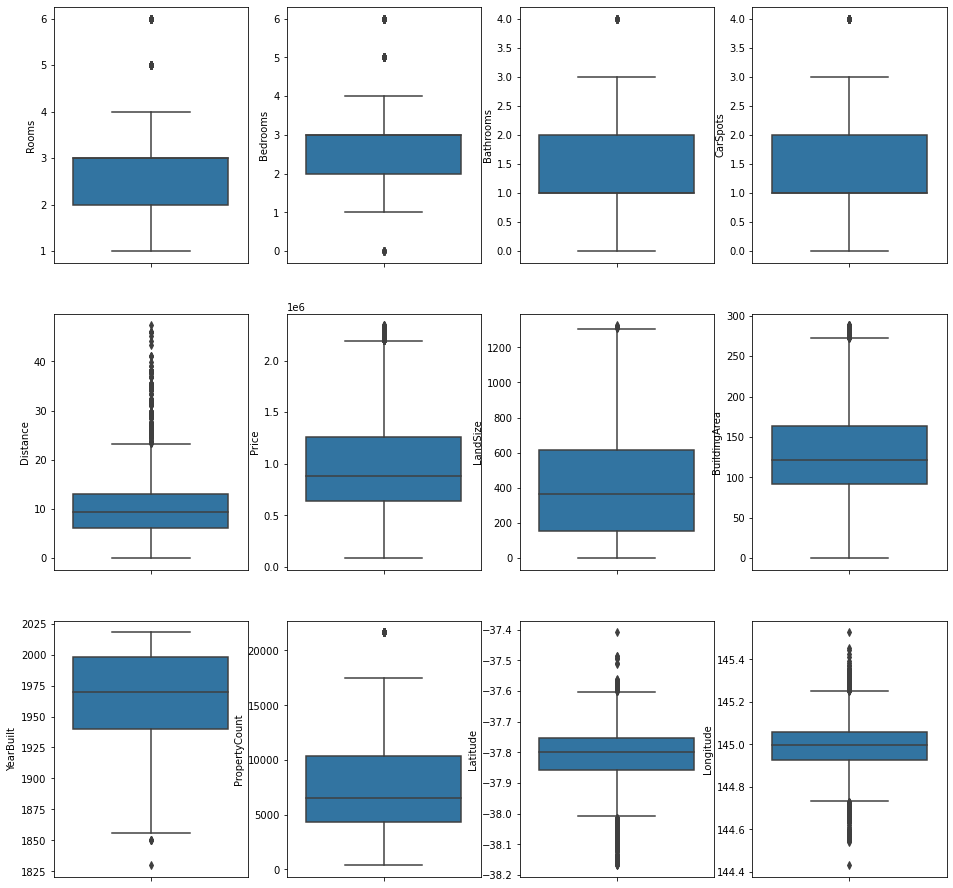

In [17]:
f, ax = plt.subplots(3, 4, figsize=(16,16))

sns.boxplot(ax=ax[0,0], data=Housing, y='Rooms')
sns.boxplot(ax=ax[0,1], data=Housing, y='Bedrooms')
sns.boxplot(ax=ax[0,2], data=Housing, y='Bathrooms')
sns.boxplot(ax=ax[0,3], data=Housing, y='CarSpots')
sns.boxplot(ax=ax[1,0], data=Housing, y='Distance')
sns.boxplot(ax=ax[1,1], data=Housing, y='Price')
sns.boxplot(ax=ax[1,2], data=Housing, y='LandSize')
sns.boxplot(ax=ax[1,3], data=Housing, y='BuildingArea')
sns.boxplot(ax=ax[2,0], data=Housing, y='YearBuilt')
sns.boxplot(ax=ax[2,1], data=Housing, y='PropertyCount')
sns.boxplot(ax=ax[2,2], data=Housing, y='Latitude')
sns.boxplot(ax=ax[2,3], data=Housing, y='Longitude')

### 2.2.3 Feature engineering - Season variable instead of Date

In next step sale date was changed to year quarters. Which can be informative in modelling process.

In [18]:
Housing['Season'] = Housing['SaleDate'].dt.quarter
Housing.drop(axis=1, columns=['SaleDate'], inplace=True)
Housing.sample(5)

,Suburb,Rooms,Type,Price,Method,Distance,Bedrooms,Bathrooms,CarSpots,LandSize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longitude,RegionName,PropertyCount,Season
8217,Pascoe Vale,2,u,497000.0,SP,9.9,2.0,1.0,1.0,123.0,73.0,1970.0,Moreland,-37.71810,144.93220,Northern Metropolitan,7485.0,2
11888,Bayswater,3,h,606000.0,S,23.2,3.0,1.0,1.0,424.0,94.0,1970.0,Knox,-37.84291,145.25545,Eastern Metropolitan,5030.0,3
5997,Sunshine,2,t,410000.0,SP,12.6,2.0,2.0,2.0,204.0,85.0,2008.0,Brimbank,-37.79820,144.82300,Western Metropolitan,3755.0,2
3152,Hawthorn,1,u,488000.0,S,4.6,1.0,1.0,1.0,0.0,57.0,2004.0,Boroondara,-37.82720,145.03430,Southern Metropolitan,11308.0,4
8388,St Kilda,1,u,350000.0,VB,6.1,1.0,1.0,1.0,1236.0,194.0,1968.0,Port Phillip,-37.85850,144.98840,Southern Metropolitan,13240.0,3


<AxesSubplot:xlabel='Season', ylabel='Price'>

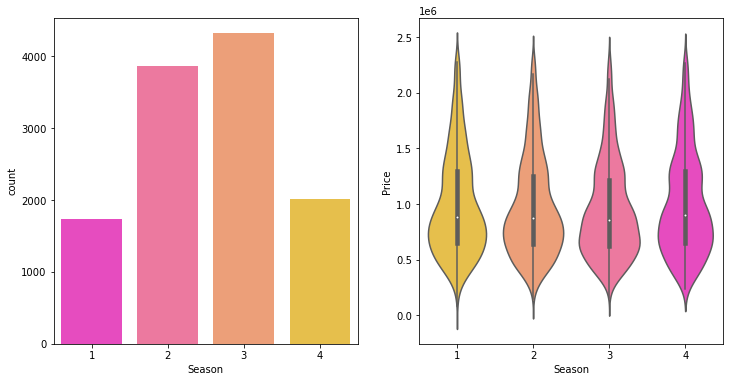

In [19]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(ax=ax[0], x=Housing['Season'], palette='spring')
sns.violinplot(ax=ax[1], y=Housing['Price'], x=Housing['Season'], palette='spring_r')

### 2.2.4 Skewness of variables 

In [20]:
skew = Housing.skew(numeric_only=True)
skew = pd.DataFrame(skew, columns=['Variable skewness'])
skew

,Variable skewness
Rooms,0.193826
Price,0.788830
Distance,1.564646
Bedrooms,0.165331
Bathrooms,0.909849
CarSpots,0.592602
LandSize,0.273316
BuildingArea,0.517664
YearBuilt,-0.500064
Latitude,-0.436912


### 2.2.5 Transformation of skewed features

In [21]:
Transformed = pd.DataFrame()
to_transform = ["Distance", "PropertyCount", "Price"]

for x in to_transform:
    Transformed[f'Log{x}'] = np.log(Housing[f'{x}'] + 1)
    Transformed[f'Sqrt{x}'] = np.sqrt(Housing[f'{x}'])

Skewness above 1 was eliminated with log and sqrt transformation. Also dependent variable was transformated for better fit to model.

In [22]:
skew = Transformed.skew()
skew = pd.DataFrame(skew, columns=['Variable skewness'])
skew

,Variable skewness
LogDistance,-0.368938
SqrtDistance,0.397183
LogPropertyCount,-0.653855
SqrtPropertyCount,0.303363
LogPrice,-0.173954
SqrtPrice,0.336023


In [23]:
Housing['LogPrice'] = np.log(Housing['Price'] + 1)
Housing['LogDistance'] = np.log(Housing['Distance'] + 1)
Housing['SqrtPropertyCount'] = np.sqrt(Housing['PropertyCount'])

Housing.drop(axis=1, columns=['Price', 'Distance', 'PropertyCount'], inplace=True)

### 2.2.6 Encoding of categorical features

In [24]:
Housing.describe(include='object')

,Suburb,Type,Method,CouncilArea,RegionName
count,11938,11938,11938,11938,11938
unique,307,3,5,33,8
top,Reservoir,h,S,Moreland,Southern Metropolitan
freq,327,8138,8019,1188,3865


In [25]:
be = ce.BinaryEncoder(cols=['Suburb', 'CouncilArea'])
Housing = be.fit_transform(Housing)

In [26]:
Housing = pd.get_dummies(Housing, columns=['Type', 'Method', 'RegionName'], drop_first=True)

In [27]:
Housing.columns

Index(['Suburb_0', 'Suburb_1', 'Suburb_2', 'Suburb_3', 'Suburb_4', 'Suburb_5',
       'Suburb_6', 'Suburb_7', 'Suburb_8', 'Rooms', 'Bedrooms', 'Bathrooms',
       'CarSpots', 'LandSize', 'BuildingArea', 'YearBuilt', 'CouncilArea_0',
       'CouncilArea_1', 'CouncilArea_2', 'CouncilArea_3', 'CouncilArea_4',
       'CouncilArea_5', 'Latitude', 'Longitude', 'Season', 'LogPrice',
       'LogDistance', 'SqrtPropertyCount', 'Type_t', 'Type_u', 'Method_S',
       'Method_SA', 'Method_SP', 'Method_VB', 'RegionName_Eastern Victoria',
       'RegionName_Northern Metropolitan', 'RegionName_Northern Victoria',
       'RegionName_South-Eastern Metropolitan',
       'RegionName_Southern Metropolitan', 'RegionName_Western Metropolitan',
       'RegionName_Western Victoria'],
      dtype='object')

Categorical variables were encoded with two methods depending on unique values number. When < 10 unique values encoded with get dummies (drop_first=True reduces multicollinearity between new variables). Suburb and CouncilArea encoded with BinaryEncoder.

### 2.2.7 Multicollinearity test 

In [28]:
X = add_constant(Housing.drop(axis=1, columns=['LogPrice']))

pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
           index=X.columns)

const                                    8.993700e+06
Suburb_0                                 1.639359e+00
Suburb_1                                 1.714294e+00
Suburb_2                                 1.283243e+00
Suburb_3                                 1.259726e+00
Suburb_4                                 1.166186e+00
Suburb_5                                 1.128261e+00
Suburb_6                                 1.099460e+00
Suburb_7                                 1.119654e+00
Suburb_8                                 1.119433e+00
Rooms                                    1.198433e+01
Bedrooms                                 1.143371e+01
Bathrooms                                1.673626e+00
CarSpots                                 1.351754e+00
LandSize                                 2.053653e+00
BuildingArea                             1.508409e+00
YearBuilt                                1.300131e+00
CouncilArea_0                            1.177433e+00
CouncilArea_1               

In [29]:
Housing.drop(axis=1, columns=['Rooms'], inplace=True)

Variance inflation factor suggested that rooms and bedrooms are highly correlated and one should be deleted (As it was noted on correlation matrix). 

In [30]:
X = add_constant(Housing.drop(axis=1, columns=['LogPrice']))

vif = pd.Series([variance_inflation_factor(X.values, i) 
           for i in range(X.shape[1])], 
           index=X.columns)
vif.iloc[1:]

Suburb_0                                 1.639238
Suburb_1                                 1.714141
Suburb_2                                 1.283162
Suburb_3                                 1.259634
Suburb_4                                 1.166081
Suburb_5                                 1.128210
Suburb_6                                 1.099404
Suburb_7                                 1.119616
Suburb_8                                 1.119401
Bedrooms                                 2.305647
Bathrooms                                1.641004
CarSpots                                 1.351537
LandSize                                 2.047851
BuildingArea                             1.499683
YearBuilt                                1.299324
CouncilArea_0                            1.177273
CouncilArea_1                            2.214208
CouncilArea_2                            1.870032
CouncilArea_3                            1.662759
CouncilArea_4                            2.362129


### 2.2.8 Train-test split

In [31]:
X = Housing.drop(axis=1, columns=['LogPrice'])
y = Housing['LogPrice'].values

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### 2.2.9 Features scalling

In [33]:
scaler = RobustScaler()

In [34]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Robust scaler ignores outliers and was applied because some of variables have significant outliers e.g. longitude and latitude. 

In [35]:
X.to_csv('../Data/PreparedFeatures.csv', sep='\t', index=False)
savetxt('../Data/X_train.csv', X_train, delimiter=',')
savetxt('../Data/y_train.csv', y_train, delimiter=',')
savetxt('../Data/X_test.csv', X_test, delimiter=',')
savetxt('../Data/y_test.csv', y_test, delimiter=',')

## 2.3 Basic models training

In [36]:
result = pd.DataFrame(columns=['Algorithm', 'Adjusted R-squared', 'MSE', 'RMSE', 'MAE'])

def results(name):
    adj_r2 = 1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    
    result.loc[len(result.index)] = [
        name, adj_r2, metrics.mean_squared_error(y_test, y_pred),
        math.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        metrics.mean_absolute_error(y_test, y_pred)
    ]

Function append to dataframe models performances.

### 2.3.1 Linear regression

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [38]:
results('Linear regression')

### 2.3.2 RANSAC regression

In [39]:
rr = RANSACRegressor(random_state=seed)
rr.fit(X_train, y_train)
y_pred = rr.predict(X_test)

In [40]:
results('RANSAC')

### 2.3.3 Random forrest regression

In [41]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [42]:
results('Random forrest')

### 2.3.4 Support vector regression

In [43]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

In [44]:
results('SVR')

### 2.3.5 XGBoost regression

In [45]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [46]:
results('XGBR')

### 2.3.6 Models performance comparison

In [47]:
result.style.background_gradient(subset=['Adjusted R-squared'], cmap='RdPu', high=0.1).highlight_min(subset=['MSE', 'RMSE', 'MAE'], color='pink')

,Algorithm,Adjusted R-squared,MSE,RMSE,MAE
0,Linear regression,0.727396,0.057905,0.240635,0.188459
1,RANSAC,0.429303,0.121225,0.348174,0.262522
2,Random forrest,0.857893,0.030186,0.173740,0.130919
3,SVR,0.856655,0.030449,0.174496,0.133717
4,XGBR,0.863789,0.028933,0.170098,0.130664


XGBoost Regressor gives best results among all algorithms in all measured values. Despite this also Random Forrest Regressor and Support Vector Regressor are considerable for further modelling. 